# Multivariate Regression

In this file I put the Value and Momentum factors in-context with each other, as well as the market return.
To note is that for simplicity I do not take excess returns, just market returns.

In [76]:
import warnings
import pandas as pd
import statsmodels.api as sm
from utils import *
from statsmodels.api import OLS
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [77]:
df = pd.read_parquet('data/regression_market_data.parquet')
sp500 = pd.read_parquet('data/sp500_index_data.parquet')
sp500['date'] = pd.to_datetime(sp500['caldt'])
sp500.set_index('date', inplace=True)
df.head()

,mthcaldt,permno,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,tradingstatusflg,...,szport,bmport,posbm,nonmissport,beme,date,me_rank,vwretx,ann_ret,momentum
636,1964-08-31,10006,NS,EQTY,COM,Y,ACOR,N,RW,A,...,B,M,1.0,1.0,0.778226,1964-08-31,190.0,-0.016279,-0.019139,NaN
637,1964-09-30,10006,NS,EQTY,COM,Y,ACOR,N,RW,A,...,B,M,1.0,1.0,0.778226,1964-09-30,186.0,0.029022,-0.098498,NaN
638,1964-10-30,10006,NS,EQTY,COM,Y,ACOR,N,RW,A,...,B,M,1.0,1.0,0.778226,1964-10-31,184.0,0.007657,-0.029525,NaN
639,1964-11-30,10006,NS,EQTY,COM,Y,ACOR,N,RW,A,...,B,M,1.0,1.0,0.778226,1964-11-30,188.0,-0.004660,-0.017443,NaN
640,1964-12-31,10006,NS,EQTY,COM,Y,ACOR,N,RW,A,...,B,M,1.0,1.0,0.778226,1964-12-31,193.0,0.003802,0.121360,NaN


We start with a rolling regression across every firm, using the past 5 years of data to predict the next year's return. The predicted returns from this model will be used in our strategy step to score assets, we will long assets in the upper quartile of expected returns, and short assets in the lower quartile.

In [78]:
regression_df = df[['date', 'permno', 'beme', 'momentum', 'ann_ret', 'vwretx', 'mthret', 'me']]
counter = 0
number_of_firms = len(regression_df['permno'].unique())
for firm in regression_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = regression_df[regression_df['permno'] == firm].sort_values('date').dropna(subset=['beme', 'ann_ret', 'momentum', 'vwretx']).reset_index()
    for i in range(12 * 5 + 1, len(subset)):
        X = subset.loc[i - 12 * 5:i - 1, ['beme', 'momentum', 'vwretx']]
        X = sm.add_constant(X)
        y = subset.loc[i - 12 * 5:i - 1, 'ann_ret']
        
        model = sm.OLS(y, X).fit()
        
        # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
        regression_df.loc[(regression_df['permno'] == firm) & (regression_df['date'] == subset.iloc[i]['date']), 'alpha'] = model.params[0]
        regression_df.loc[(regression_df['permno'] == firm) & (regression_df['date'] == subset.iloc[i]['date']), 'beme_beta'] = model.params[1]
        regression_df.loc[(regression_df['permno'] == firm) & (regression_df['date'] == subset.iloc[i]['date']), 'momentum_beta'] = model.params[2]
        regression_df.loc[(regression_df['permno'] == firm) & (regression_df['date'] == subset.iloc[i]['date']), 'market_beta'] = model.params[3]

4846essing firm 100.00%


,date,permno,beme,momentum,ann_ret,vwretx,mthret,me,alpha,beme_beta,momentum_beta,market_beta
636,1964-08-31,10006,0.778226,NaN,-0.019139,-0.016279,0.012792,231786.5,NaN,NaN,NaN,NaN
637,1964-09-30,10006,0.778226,NaN,-0.098498,0.029022,0.074722,249106.0,NaN,NaN,NaN,NaN
638,1964-10-31,10006,0.778226,NaN,-0.029525,0.007657,0.029586,256476.0,NaN,NaN,NaN,NaN
639,1964-11-30,10006,0.778226,NaN,-0.017443,-0.004660,-0.023469,248369.0,NaN,NaN,NaN,NaN
640,1964-12-31,10006,0.778226,NaN,0.121360,0.003802,-0.056380,235956.0,NaN,NaN,NaN,NaN


We shift the beta values by 12 months to avoid forward looking bias.

In [79]:
regression_df['alpha'] = regression_df.groupby('permno')['alpha'].shift(12)
regression_df['beme_beta'] = regression_df.groupby('permno')['beme_beta'].shift(12)
regression_df['momentum_beta'] = regression_df.groupby('permno')['momentum_beta'].shift(12)
regression_df['market_beta'] = regression_df.groupby('permno')['market_beta'].shift(12)
regression_df['predict'] = regression_df['alpha'] + regression_df['beme_beta'] * regression_df['beme'] + regression_df['momentum_beta'] * regression_df['momentum'] + regression_df['market_beta'] * regression_df['vwretx']

,date,permno,beme,momentum,ann_ret,vwretx,mthret,me,alpha,beme_beta,momentum_beta,market_beta,predict
636,1964-08-31,10006,0.778226,NaN,-0.019139,-0.016279,0.012792,231786.5,NaN,NaN,NaN,NaN,NaN
637,1964-09-30,10006,0.778226,NaN,-0.098498,0.029022,0.074722,249106.0,NaN,NaN,NaN,NaN,NaN
638,1964-10-31,10006,0.778226,NaN,-0.029525,0.007657,0.029586,256476.0,NaN,NaN,NaN,NaN,NaN
639,1964-11-30,10006,0.778226,NaN,-0.017443,-0.004660,-0.023469,248369.0,NaN,NaN,NaN,NaN,NaN
640,1964-12-31,10006,0.778226,NaN,0.121360,0.003802,-0.056380,235956.0,NaN,NaN,NaN,NaN,NaN


Here we plot the average Market Return Beta. We find that in the period 1970 to 1976 and 1985 to 1990 the market beta is consistently negative (When in-context with the other factors). This could be due to our Momentum factor capturing most of the relationship, but it could be a data artifact. I put the investigation of the negative Market Beta as future work.

<Axes: xlabel='date'>

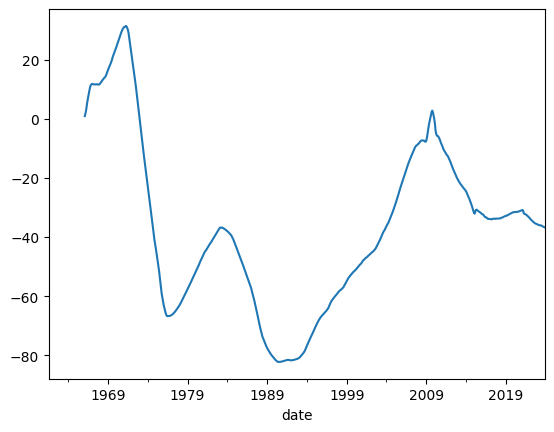

In [80]:
x = regression_df.groupby('date')['market_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

Here we plot our Value Coefficient, and we see a cleaner result as compared to our univariate regressions. The relationship is more stable, and the coefficient is consistently positive.

<Axes: xlabel='date'>

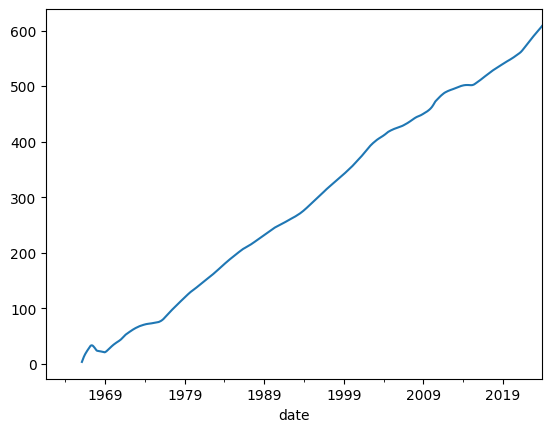

In [81]:
x = regression_df.groupby('date')['beme_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

Here we plot our momentum coefficient sum and we see a stable positive relationship as well.

<Axes: xlabel='date'>

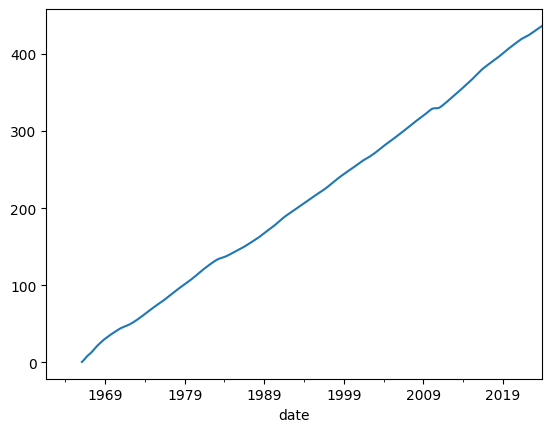

In [82]:
x = regression_df.groupby('date')['momentum_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

Our Actual vs predicted shows us a poor fit, with a lot of noise. Looking at the residuals we miss the larger movements, and this is due to the linear nature of our model. However, the relationship is monotonic, which is good for our initial purposes.

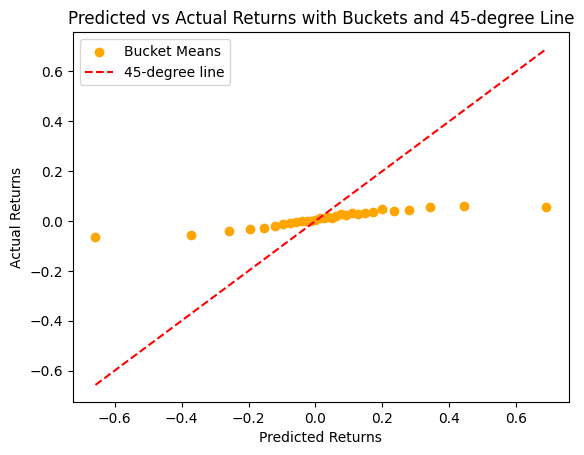

In [83]:
plot_actual_vs_predicted(regression_df, 'predict', 'ann_ret')

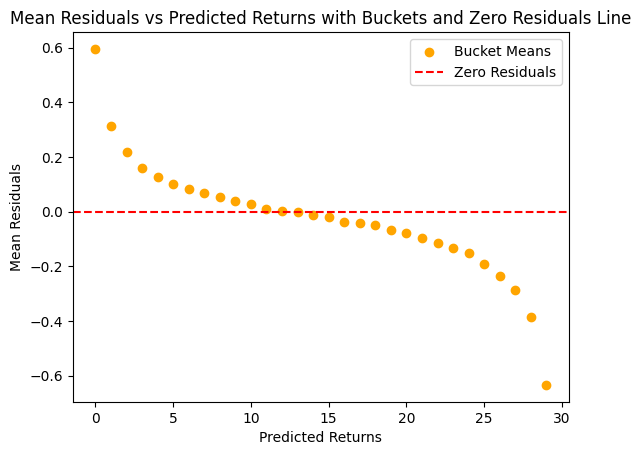

In [84]:
plot_residuals(regression_df, 'predict', 'ann_ret')

We can now try a more traditional crossectional regression across the entire time period for each asset.

In [89]:
counter = 0
missed_firms = 0
r2 = []
for firm in regression_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = regression_df[regression_df['permno'] == firm].sort_values('date').dropna(subset=['beme', 'ann_ret', 'momentum', 'vwretx']).reset_index()
    X = subset[['beme', 'momentum', 'vwretx']]
    X = sm.add_constant(X)
    y = subset['ann_ret']
    if len(X) < 12*2:
        missed_firms += 1
        continue
    
    model = sm.OLS(y, X).fit()
    
    # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
    regression_df.loc[(regression_df['permno'] == firm), 'cs_alpha'] = model.params[0]
    regression_df.loc[(regression_df['permno'] == firm), 'cs_beme_beta'] = model.params[1]
    regression_df.loc[(regression_df['permno'] == firm), 'cs_momentum_beta'] = model.params[2]
    regression_df.loc[(regression_df['permno'] == firm), 'cs_market_beta'] = model.params[3]
    r2.append(model.rsquared)
print(missed_firms/counter)

0.57985967808501860.00%


Our R2 distribution indicates poor model fit, with an average R2 of only 24%. This suggests that additional factors may be necessary to explain a greater portion of the return variation. The few instances of higher R2 values are likely attributable to smaller sample sizes, which can lead to overfitting.

0.24193890093981293


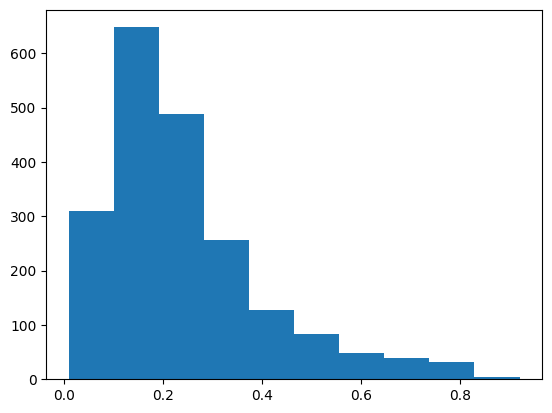

In [93]:
#Histogram of R2
plt.hist(r2)
print(sum(r2) / len(r2))

We find a strong fit, with the residuals flat bar extreme values, returns aren't perfectly normal so this aligns with our priors. Windsorization or just noting this caveat allows us to use the model's information. The fit looks much stronger with the predicted vs actual, however we know this is an endogenous fit and we should be careful with our conclusions.

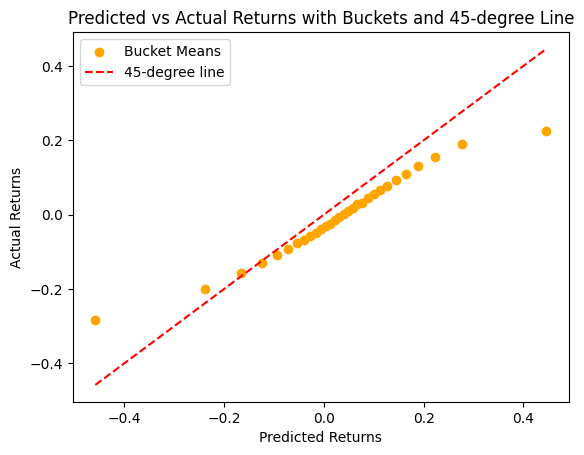

In [86]:
regression_df['cs_predict'] = regression_df['cs_alpha'] + regression_df['cs_beme_beta'] * regression_df['beme'] + regression_df['cs_momentum_beta'] * regression_df['momentum'] + regression_df['cs_market_beta'] * regression_df['vwretx']

plot_actual_vs_predicted(regression_df, 'cs_predict', 'ann_ret')

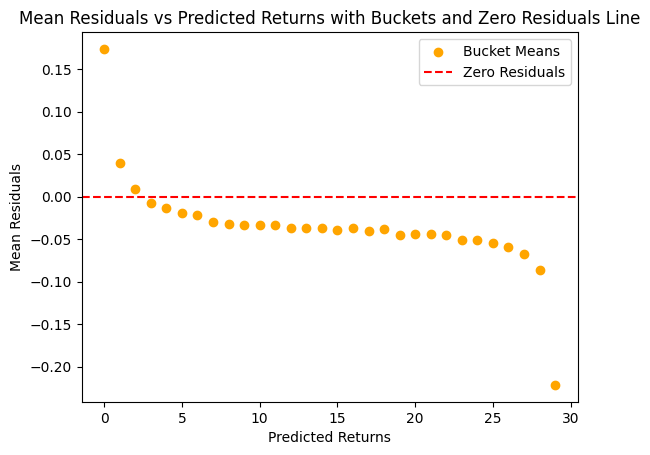

In [87]:
plot_residuals(regression_df, 'cs_predict', 'ann_ret')

In [88]:
regression_df.to_parquet('data/market_data_w_z_scores.parquet')